In [1]:
import pandas as pd
import pickle
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import numpy as np
%matplotlib inline
import itertools
import matplotlib.pyplot as plt

In [1]:
!nvidia-smi

Thu Jan 14 15:26:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   31C    P0    24W / 250W |      8MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [2]:
!ps aux | grep 1698

root        1698  0.0  0.0 2847244 172204 tty7   Ssl+  2020  10:33 /usr/lib/xorg/Xorg -core :0 -seat seat0 -auth /var/run/lightdm/root/:0 -nolisten tcp vt7 -novtswitch
gsinha1  3046415 48.0  0.0   9492  3400 pts/53   Ss+  15:27   0:00 /bin/bash -c ps aux | grep 1698
gsinha1  3046417  0.0  0.0   8900   732 pts/53   S+   15:27   0:00 grep 1698


In [2]:

def plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                         figsize = (10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm =np.round(cm,2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.rcParams["figure.figsize"] = figsize
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
lab13 = [
    'angry',
    'ashamed',
    'afraid',
    'sentimental',
    'hopeful',
    #'apprehensive',
    'sad',
    'happy',
    'faithful',
    #'confident',
    'caring',
    'grateful',
    'impressed',
    'jealous',
    'surprised'
]
lab14 = [
    'angry',
    'ashamed',
    'afraid',
    'sentimental',
    'hopeful',
    #'apprehensive',
    'sad',
    'happy',
    'faithful',
    'confident',
    'caring',
    'grateful',
    'impressed',
    'jealous',
    'surprised'
]

In [4]:
model_names = [
    '13_nw',
    '13_w',
    '14_nw',
    '14_w',
    '14_rms'
]

In [5]:
dir_p = '../data/'
val_fnames = [
    'val_data_13_nw_anx_df.p',
    'val_data_13_w_anx_df.p',
    'val_data_14_nw_anx_df.p',
    'val_data_14_w_anx_df.p',
    'val_data_14_w_rms_anx_df.p',
]
val_fnames = [dir_p+fname for fname in val_fnames]

gpt2_fnames = [
    'gpt2_13_no_weight_anxious_df.p',
    'gpt2_13_weight_anxious_df.p',
    'gpt2_14_no_weight_anxious_df.p',
    'gpt2_14_weighted_anxious_df.p',
    'gpt2_14_rms_weighted_anxious_df.p',
]
gpt2_fnames = [dir_p+fname for fname in gpt2_fnames]

In [6]:
val_data = {}
for i in range(len(model_names)):
    val_data[model_names[i]]=pickle.load(open(val_fnames[i],'rb'))

In [7]:
gpt2_data = {}
for i in range(len(model_names)):
    gpt2_data[model_names[i]]=pickle.load(open(gpt2_fnames[i],'rb'))

In [8]:
val_data['14_w']

,Text,Target,Predicted,logits
0,My son is never here anymore. He is growing u...,sad,sad,6.047729
1,A friend forgot his phone at the library. I r...,caring,caring,8.104232
2,I was on lunch and my coworker made me laugh. ...,ashamed,ashamed,4.888098
3,"I decided to go fishing last week, and did my ...",confident,confident,5.484104
4,The other day an intruder broke into my home.,afraid,afraid,5.972203
...,...,...,...,...
2731,I'm promoting two staff members on Sunday. The...,caring,happy,6.414848
2732,I was planning to go biking this weekend but i...,sad,sad,3.751997
2733,I received interesting gifts on my birthday,happy,surprised,7.903016
2734,My sister in law and her fiance are taking all...,jealous,jealous,8.351763


**Scores to evaluate:**
- Accuracy
- F1
- Percent Captured : Larger the better

Then draw confusion matrix for each and histogram for each

In [9]:
#Accuracy
error_tolerance = 0.12
accuracies = []
f1s = []
mif1s=[]
percent_cap = []
model_thresh = []
cms = []
for mn in model_names:
    y_pred = val_data[mn]['Predicted']
    y_true = val_data[mn]['Target']
    val_logits = np.array(val_data[mn]['logits'])
    gpt2_logits = np.array(gpt2_data[mn]['logits'])
    gpt2_logits.sort()
    accuracies.append(accuracy_score(y_true,y_pred))
    f1s.append(np.mean(f1_score(y_true,y_pred,average='macro')))
    mif1s.append(np.mean(f1_score(y_true,y_pred,average='micro')))
    cms.append(confusion_matrix(y_true,y_pred))
    thresh = np.quantile(val_logits,error_tolerance)
    model_thresh.append(thresh)
    percent_cap.append(np.mean(gpt2_logits<thresh))
    



In [10]:
results = pd.DataFrame({
    'Model':model_names,
    'Mean Accuracy': accuracies,
    'Macro F1': f1s,
    'Micro F1': mif1s,
    'Percent Captured': percent_cap,
    'Threshold': model_thresh
})

In [11]:
results

,Model,Mean Accuracy,Macro F1,Micro F1,Percent Captured,Threshold
0,13_nw,0.791301,0.771441,0.791301,0.704616,3.971279
1,13_w,0.763889,0.749264,0.763889,0.721697,4.007181
2,14_nw,0.768640,0.752517,0.768640,0.756971,3.758093
3,14_w,0.762427,0.742547,0.762427,0.739096,4.504224
4,14_rms,0.777047,0.758616,0.777047,0.529673,1.825285


In [14]:
pickle.dump(results,open("../model/BART_14_weight_anxious/results.p",'wb'))

Normalized confusion matrix


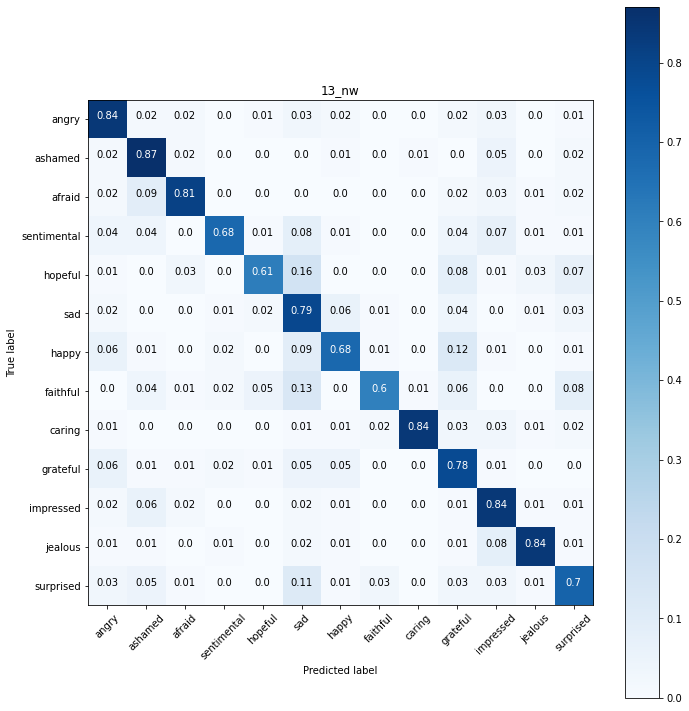

In [29]:
i=0
plot_confusion_matrix(cms[i],lab13,title=model_names[i])

Normalized confusion matrix


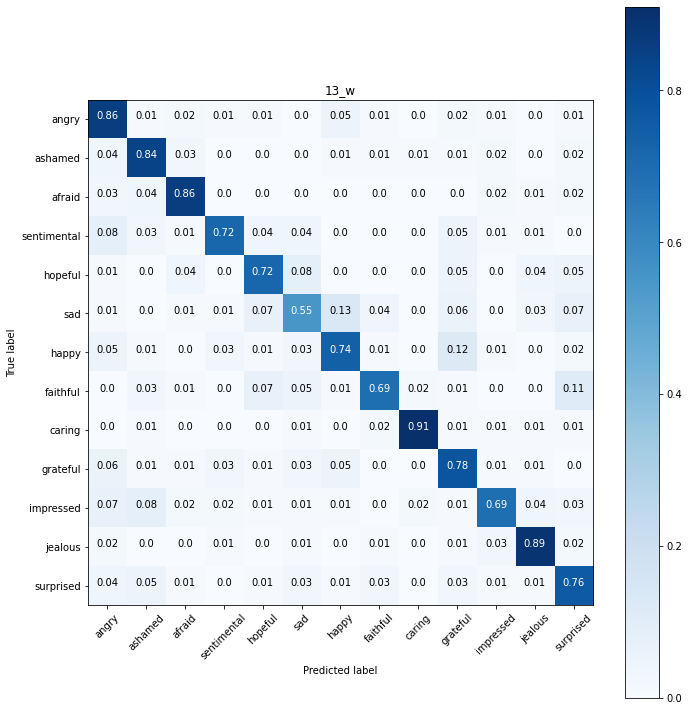

In [13]:
i=1
plot_confusion_matrix(cms[i],lab13,title=model_names[i])

Normalized confusion matrix


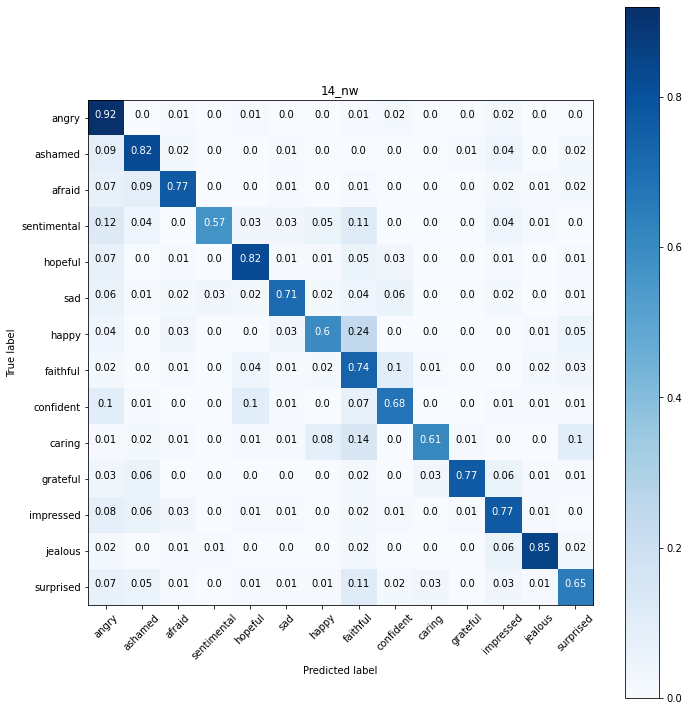

In [14]:
i=2
plot_confusion_matrix(cms[i],lab14,title=model_names[i])

Normalized confusion matrix


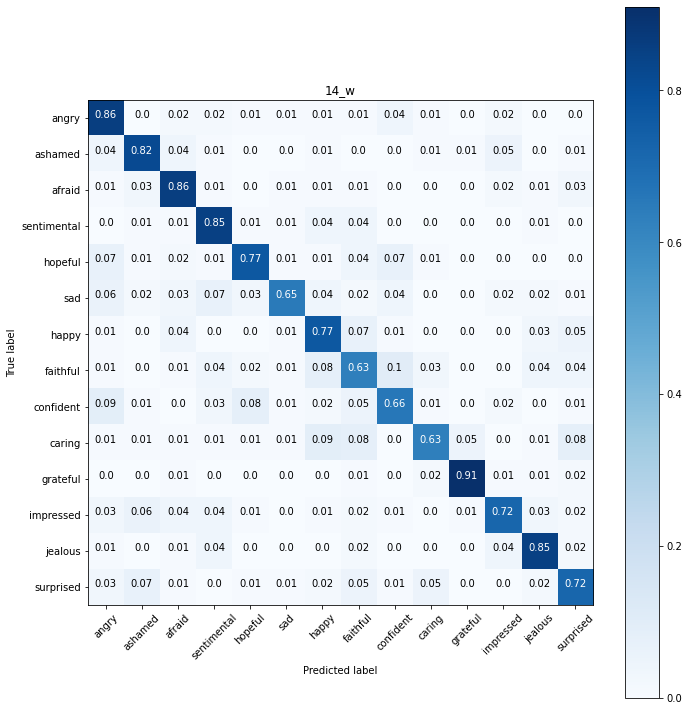

In [15]:
i=3
plot_confusion_matrix(cms[i],lab14,title=model_names[i])

Normalized confusion matrix


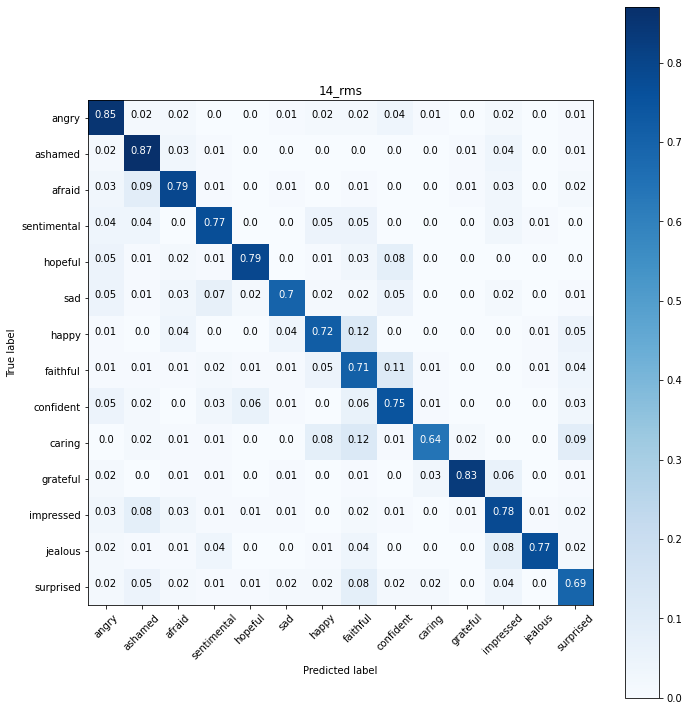

In [16]:
i=4
plot_confusion_matrix(cms[i],lab14,title=model_names[i])

In [17]:
pd.set_option('display.max_colwidth', 0)
val_data['14_w'].groupby('Target').agg('count')

,Text,Predicted,logits
Target,,,
afraid,325,325,325
angry,360,360,360
ashamed,232,232,232
caring,74,74,74
confident,189,189,189
faithful,120,120,120
grateful,75,75,75
happy,351,351,351
hopeful,154,154,154


In [18]:
gpt2_data['14_w'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12587 entries, 0 to 12586
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       12587 non-null  object 
 1   Target     12587 non-null  object 
 2   Predicted  12587 non-null  object 
 3   logits     12587 non-null  float64
dtypes: float64(1), object(3)
memory usage: 393.5+ KB


In [19]:
df = pickle.load(open("../data/empathy_cls_df.p","rb"))

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17839 entries, hit:0_conv:1 to hit:9_conv:19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  17839 non-null  object
 1   prompt   17839 non-null  object
dtypes: object(2)
memory usage: 418.1+ KB


In [21]:
df.groupby('context').agg('count')

,prompt
context,
afraid,586
angry,637
annoyed,615
anticipating,561
anxious,572
apprehensive,421
ashamed,446
caring,477
confident,568


In [22]:
val_data['14_w']['logits']

0       6.047729
1       8.104232
2       4.888098
3       5.484104
4       5.972203
          ...   
2731    6.414848
2732    3.751997
2733    7.903016
2734    8.351763
2735    8.490528
Name: logits, Length: 2736, dtype: float64

In [23]:
ques_df = pickle.load(open('../data/gpt2_14_w_ques_df.p','rb'))

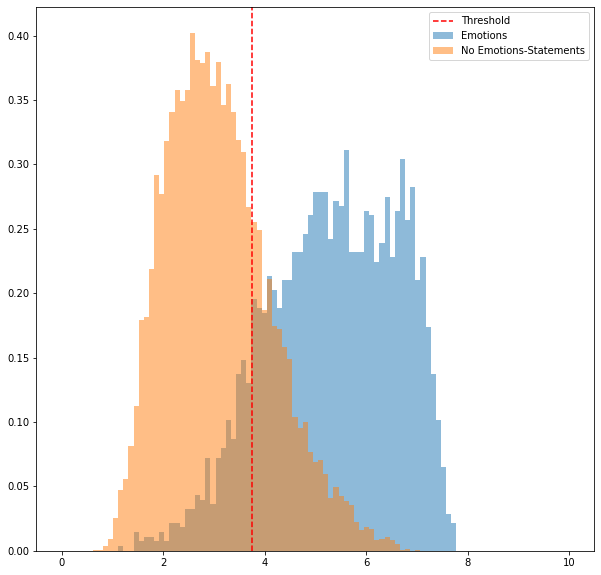

In [34]:
mod_name='14_nw'
bins = np.linspace(0, 10, 100)

plt.hist(val_data[mod_name]['logits'], bins, alpha=0.5, label='Emotions',density= True)
plt.hist(gpt2_data[mod_name]['logits'],bins, alpha=0.5, label='No Emotions-Statements',density= True)
#plt.hist(ques_df.logits,bins, alpha=0.5, label='No Emotions-Questions',density= True)
plt.axvline(x=results.query('Model==@mod_name')['Threshold'].item(), c = 'red',ls='--',animated=True,label ='Threshold')
plt.legend(loc='upper right')
plt.show()

In [25]:
np.mean(ques_df.logits<results.query('Model==@mod_name')['Threshold'].item())

0.8747327917913639